<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Seismometer-records-of-ground-tilt-induced-by-debris-flows" data-toc-modified-id="Seismometer-records-of-ground-tilt-induced-by-debris-flows-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Seismometer records of ground tilt induced by debris flows</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#Convert-seismic-data-to-tilt" data-toc-modified-id="Convert-seismic-data-to-tilt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Convert seismic data to tilt</a></span><ul class="toc-item"><li><span><a href="#Illgraben" data-toc-modified-id="Illgraben-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Illgraben</a></span></li><li><span><a href="#USGS-debris-flow-flume" data-toc-modified-id="USGS-debris-flow-flume-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>USGS debris flow flume</a></span></li></ul></li><li><span><a href="#Get-correlations" data-toc-modified-id="Get-correlations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get correlations</a></span></li><li><span><a href="#Model-tilt" data-toc-modified-id="Model-tilt-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model tilt</a></span><ul class="toc-item"><li><span><a href="#Step-in-acceleration" data-toc-modified-id="Step-in-acceleration-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Step in acceleration</a></span></li></ul></li></ul></li></ul></div>

# Seismometer records of ground tilt induced by debris flows 
Code by Michaela Wenner, publication submitted to BSSA

**ABSTRACT**

A change in surface loading causes the Earth’s surface to deform. Mass movements, such as
debris flows, can cause a tilt large enough to be recorded by nearby instruments, but the signal
is strongly dependent on the mass loading and sub-surface parameters. Specifically designed
sensors for such measurements (tiltmeters) are cumbersome to install. Alternatively, broadband
seismometers record, in addition to translational motion, tilt signals at periods of tens to hundreds
of seconds, with the horizontal components most sensitive to tilt. In this study, we show how to
obtain tilt caused by the passing-by of debris flows from seismic measurements recorded within
tens of meters of the flow and investigate the usefulness of this signal for flow characterization. We
investigate the problem on three scale 1) large-scale laboratory experiments at the U.S. Geological
Survey debris-flow flume, where broadband seismometers and tiltmeters were installed for six
8-10 m3 experiments, 2) the Illgraben torrent in Switzerland, one of the most active mass wasting
sites in the European Alps, where a broadband seismometer placed within a few meters of the
channel recorded 15 debris-flow events with volumes up to 105 m3, and 3) Volc ́an de Fuego,
Guatemala, where a broadband seismometer recorded two lahars. We investigate how the tilt
signals compare to debris-flow parameters such as mean normal stresses, usually measured by
expensive force plates, and debris-flow height. We model the elastic ground deformation as the
response of an elastic half-space to a moving surface load. Additionally, we use the model with
some simplifications to determine maximum debris-flow heights of Volca ́n de Fuego events, where
no force-plate measurements are available. Finally, we address how and under what assumptions
the relatively affordable and straightforward tilt measurements may be utilized to infer debris-flow
parameters, as opposed to force plates and other complicated instrument setups.

''
I apologize in advance for potentially confusingly coded and/or hard to read code. I hope it helps you anyway!
''



# Code

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import obspy
from scipy import signal
import matplotlib
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'font.size': 14})

In [78]:
# Helper functions
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Read in tilt data
class tilt():
    def __init__(self, t, loc, station):
        year = t.year
        self.time = t
        if loc == 'Illgraben':
            if t.year == 2020:
                channel = "HH*"
            else:
                channel = "BH*"
            self.stream = obspy.read(f'../data/illgraben_seismic_data/raw_data/{year}/ILL11/{channel}.D/*{self.time.julday}')

            if t.hour > 21:
                self.stream += obspy.read(f'../data/illgraben_seismic_data/raw_data/{year}/ILL11/{channel}.D/*{self.time.julday + 1}') 
            elif t.hour < 2:
                self.stream += obspy.read(f'../data/illgraben_seismic_data/raw_data/{year}/ILL11/{channel}.D/*{self.time.julday - 1}') 
            self.stream.merge(fill_value='interpolate')
            self.inventory = obspy.read_inventory('../data/illgraben_seismic_data/response/ILL11_inventory.xml')   
            self.stream.attach_response(self.inventory)
        elif loc == 'USGS':
            self.stream = obspy.read(f'../data/{loc}_seismic_data/ZK/{station}/ZK.{station}....2016.{self.time.julday}')
            self.inventory = obspy.read_inventory(f'../data/{loc}_seismic_data/response/usgs_{station}_2016.xml')   
            self.stream.attach_response(self.inventory)

In [15]:
# Get general information on all tilt events
info = pd.read_csv("../data/00_info_tilt_events.csv")
info

,year,julday,time,location,multi_surge,fp_data,volume,velocity,h99,max_tilt,max_tilt_0,total_run_time,daily_precipitation_[mm],area_under_tilt,start,end
0,2019,161,2019-06-10T18:35:51,Illgraben,0,True,3300.0,0.90,0.64,0.74,0.74,0,0.00,591.0,3582.0,6488.0
1,2019,161,2019-06-10T23:12:52,Illgraben,1,True,6600.0,2.38,0.59,1.40,0.20,0,0.00,444.0,3474.0,8040.0
2,2019,172,2019-06-21T19:45:07,Illgraben,0,True,83000.0,5.60,2.45,4.40,4.40,0,0.00,1659.0,3535.0,6070.0
3,2019,182,2019-07-01T23:30:31,Illgraben,0,True,NaN,NaN,NaN,1.90,1.90,0,0.00,1076.0,3471.0,7057.0
4,2019,183,2019-07-02T22:47:14,Illgraben,0,True,78000.0,3.80,1.62,1.10,1.10,0,0.00,920.0,3600.0,8341.0
5,2019,184,2019-07-03T18:13:35,Illgraben,1,False,39000.0,2.50,0.70,NaN,NaN,0,0.00,NaN,NaN,NaN
6,2019,196,2019-07-15T04:22:58,Illgraben,1,True,16000.0,5.00,0.68,0.75,0.10,0,0.00,551.0,3454.0,7143.0
7,2019,207,2019-07-26T17:50:54,Illgraben,0,True,64000.0,6.97,1.21,1.80,1.80,0,0.00,669.0,3535.0,5889.0
8,2019,223,2019-08-11T17:12:16,Illgraben,1,True,53000.0,5.56,NaN,NaN,NaN,0,0.00,NaN,NaN,NaN
9,2019,232,2019-08-20T17:10:14,Illgraben,1,True,13000.0,0.95,0.89,1.00,1.00,0,0.00,643.0,3460.0,6236.0


## Convert seismic data to tilt
### Illgraben

In [16]:
# Get information from info file
loc = "Illgraben" # Set location
df = info[info['location'] == loc].copy().reset_index() 

In [54]:
def tilt_below_fc(st, inv, filt):
    """
    Get tilt for frequencies below corner frequency (after Aoyama 2008)
    :param st: Stream containing horizontal and vertical compontents
    :type st: obspy.core.stream.Stream
    :param inv: Inventory containing belonging instrument responses
    :type inv: obspy.core.inventory.inventory.Inventory
    :return: obspy Stream containing rotatet seismic data converted to tilt in microradians
    """
    st1 = st.copy()
    #st1.rotate(method='->ZNE', inventory=inv)
    #st1.rotate('NE->RT', back_azimuth=55.+180.).detrend('demean')
    fc = 1/120 # Corner frequency in Hz
    w0 = 2 * np.pi * fc
    sens = 1/st1[0].stats.response.instrument_sensitivity.value
    
    g = -9.81
    
    if filt =='bandpass':
        st1.filter('bandpass', freqmin = 1/(7200), freqmax=1/120, corners=2, zerophase=True)
    elif filt == 'lowpass':
        st1.filter('lowpass', freq = 1/120, corners=2, zerophase=True)
    st1.detrend('demean')
    st1.detrend('linear')
    st1.integrate()
    
    
    #st1.filter('lowpass', freq = 1/10, corners=2, zerophase=True)
    fac = (sens*(w0**2))/ g
    for tr in st1:
        tr.data = fac *tr.data *1e6
    return st1

In [55]:
# Define window length of data
tc = 3600 # 3x3600s will be taken from data
station = "ILL11"

for idx, row in df.iterrows(): 
    # Read data files and preprocess data
    t = obspy.UTCDateTime(row['time'])
    print(f"{loc}, Event: {t}")
    ti = tilt(t, loc, "ILL11")
    print(ti.stream)
    st = ti.stream.copy()
    st.trim(t - 1*tc, t + 2*tc)
    st.copy().write(f'../data/{loc}_seismic_data/trimmed_data/{loc}_{t.isoformat()}_signal.mseed', format='MSEED')
    # Downsample to one sample
    st.resample(1)
    # Get sensitivitz
    sens = st[0].stats.response.instrument_sensitivity.value

    # Demean/taper
    st.merge(fill_value='interpolate')
    st.detrend('demean')
    st.detrend('linear')
    st.taper(0.01)

    # Get tilt
    filt = 'bandpass'
    st1 = tilt_below_fc(st, ti.inventory, filt)
    
    # Only save radial component
    tra = st1[0].copy()
    tra.write(f'../data/{loc}_tilt_data/{loc}_{t.isoformat()}_tilt.mseed', format='MSEED')


Illgraben, Event: 2019-06-10T18:35:51.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHZ | 2019-06-10T00:00:03.035000Z - 2019-06-11T00:00:02.535000Z | 50.0 Hz, 4319976 samples
XP.ILL11..BHE | 2019-06-10T00:00:04.535000Z - 2019-06-11T00:00:00.575000Z | 50.0 Hz, 4319803 samples
XP.ILL11..BHN | 2019-06-10T00:00:06.245000Z - 2019-06-11T00:00:03.405000Z | 50.0 Hz, 4319859 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-06-10T23:12:52.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHZ | 2019-06-10T00:00:03.035000Z - 2019-06-12T00:00:00.675000Z | 50.0 Hz, 8639883 samples
XP.ILL11..BHE | 2019-06-10T00:00:04.535000Z - 2019-06-12T00:00:05.455000Z | 50.0 Hz, 8640047 samples
XP.ILL11..BHN | 2019-06-10T00:00:06.245000Z - 2019-06-12T00:00:00.865000Z | 50.0 Hz, 8639732 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-06-21T19:45:07.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHE | 2019-06-21T00:00:02.515000Z - 2019-06-22T00:00:02.135000Z | 50.0 Hz, 4319982 samples
XP.ILL11..BHN | 2019-06-21T00:00:04.025000Z - 2019-06-22T00:00:05.005000Z | 50.0 Hz, 4320050 samples
XP.ILL11..BHZ | 2019-06-21T00:00:03.985000Z - 2019-06-22T00:00:01.785000Z | 50.0 Hz, 4319891 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-07-01T23:30:31.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHE | 2019-07-01T00:00:02.475000Z - 2019-07-03T00:00:00.395000Z | 50.0 Hz, 8639897 samples
XP.ILL11..BHN | 2019-07-01T00:00:01.215000Z - 2019-07-03T00:00:03.755000Z | 50.0 Hz, 8640128 samples
XP.ILL11..BHZ | 2019-07-01T00:00:02.785000Z - 2019-07-03T00:00:03.025000Z | 50.0 Hz, 8640013 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-07-02T22:47:14.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHE | 2019-07-02T00:00:01.915000Z - 2019-07-04T00:00:04.595000Z | 50.0 Hz, 8640135 samples
XP.ILL11..BHN | 2019-07-02T00:00:02.335000Z - 2019-07-04T00:00:02.675000Z | 50.0 Hz, 8640018 samples
XP.ILL11..BHZ | 2019-07-02T00:00:02.305000Z - 2019-07-04T00:00:00.205000Z | 50.0 Hz, 8639896 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-07-03T18:13:35.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHN | 2019-07-03T00:00:03.775000Z - 2019-07-04T00:00:02.675000Z | 50.0 Hz, 4319946 samples
XP.ILL11..BHZ | 2019-07-03T00:00:01.285000Z - 2019-07-04T00:00:00.205000Z | 50.0 Hz, 4319947 samples
XP.ILL11..BHE | 2019-07-03T00:00:00.415000Z - 2019-07-04T00:00:04.595000Z | 50.0 Hz, 4320210 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-07-15T04:22:58.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHE | 2019-07-15T00:00:04.835000Z - 2019-07-16T00:00:04.695000Z | 50.0 Hz, 4319994 samples
XP.ILL11..BHN | 2019-07-15T00:00:05.065000Z - 2019-07-16T00:00:02.885000Z | 50.0 Hz, 4319892 samples
XP.ILL11..BHZ | 2019-07-15T00:00:00.785000Z - 2019-07-16T00:00:02.545000Z | 50.0 Hz, 4320089 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-07-26T17:50:54.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHE | 2019-07-26T00:00:01.495000Z - 2019-07-27T00:00:05.215000Z | 50.0 Hz, 4320187 samples
XP.ILL11..BHN | 2019-07-26T00:00:06.215000Z - 2019-07-27T00:00:02.795000Z | 50.0 Hz, 4319830 samples
XP.ILL11..BHZ | 2019-07-26T00:00:00.515000Z - 2019-07-27T00:00:04.475000Z | 50.0 Hz, 4320199 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-08-11T17:12:16.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHZ | 2019-08-11T00:00:04.365000Z - 2019-08-12T00:00:06.165000Z | 50.0 Hz, 4320091 samples
XP.ILL11..BHE | 2019-08-11T00:00:03.975000Z - 2019-08-12T00:00:05.095000Z | 50.0 Hz, 4320057 samples
XP.ILL11..BHN | 2019-08-11T00:00:04.465000Z - 2019-08-12T00:00:02.905000Z | 50.0 Hz, 4319923 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2019-08-20T17:10:14.000000Z
3 Trace(s) in Stream:
XP.ILL11..BHE | 2019-08-20T00:00:00.775000Z - 2019-08-21T00:00:00.915000Z | 50.0 Hz, 4320008 samples
XP.ILL11..BHN | 2019-08-20T00:00:06.725000Z - 2019-08-21T00:00:04.425000Z | 50.0 Hz, 4319886 samples
XP.ILL11..BHZ | 2019-08-20T00:00:03.395000Z - 2019-08-21T00:00:02.115000Z | 50.0 Hz, 4319937 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-06-04T15:42:22.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-04T00:00:00.580000Z - 2020-06-05T00:00:02.060000Z | 100.0 Hz, 8640149 samples
XP.ILL11..HHN | 2020-06-04T00:00:01.850000Z - 2020-06-05T00:00:01.100000Z | 100.0 Hz, 8639926 samples
XP.ILL11..HHZ | 2020-06-04T00:00:02.410000Z - 2020-06-05T00:00:00.410000Z | 100.0 Hz, 8639801 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-06-07T09:27:19.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-07T00:00:00.030000Z - 2020-06-08T00:00:00.170000Z | 100.0 Hz, 8640015 samples
XP.ILL11..HHN | 2020-06-07T00:00:00.030000Z - 2020-06-08T00:00:00.510000Z | 100.0 Hz, 8640049 samples
XP.ILL11..HHZ | 2020-06-07T00:00:00.140000Z - 2020-06-08T00:00:02.060000Z | 100.0 Hz, 8640193 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-06-08T17:57:53.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-08T00:00:00.180000Z - 2020-06-09T00:00:00.590000Z | 100.0 Hz, 8640042 samples
XP.ILL11..HHN | 2020-06-08T00:00:00.520000Z - 2020-06-09T00:00:01.330000Z | 100.0 Hz, 8640082 samples
XP.ILL11..HHZ | 2020-06-08T00:00:02.070000Z - 2020-06-09T00:00:01.390000Z | 100.0 Hz, 8639933 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-06-10T00:47:46.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-09T00:00:00.600000Z - 2020-06-11T00:00:00.730000Z | 100.0 Hz, 17280014 samples
XP.ILL11..HHN | 2020-06-09T00:00:01.340000Z - 2020-06-11T00:00:02.410000Z | 100.0 Hz, 17280108 samples
XP.ILL11..HHZ | 2020-06-09T00:00:01.400000Z - 2020-06-11T00:00:01.890000Z | 100.0 Hz, 17280050 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-06-17T04:56:59.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-17T00:00:00.820000Z - 2020-06-18T00:00:02.110000Z | 100.0 Hz, 8640130 samples
XP.ILL11..HHN | 2020-06-17T00:00:00.660000Z - 2020-06-18T00:00:01.390000Z | 100.0 Hz, 8640074 samples
XP.ILL11..HHZ | 2020-06-17T00:00:00.160000Z - 2020-06-18T00:00:01.480000Z | 100.0 Hz, 8640133 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-06-29T05:37:49.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-29T00:00:00.600000Z - 2020-06-30T00:00:00.980000Z | 100.0 Hz, 8640039 samples
XP.ILL11..HHN | 2020-06-29T00:00:01.600000Z - 2020-06-30T00:00:00.570000Z | 100.0 Hz, 8639898 samples
XP.ILL11..HHZ | 2020-06-29T00:00:02.870000Z - 2020-06-30T00:00:00.510000Z | 100.0 Hz, 8639765 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-08-16T23:02:05.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-08-16T00:00:03.070000Z - 2020-08-17T00:00:01.950000Z | 100.0 Hz, 8639889 samples
XP.ILL11..HHN | 2020-08-16T00:00:03.840000Z - 2020-08-18T00:00:03.560000Z | 100.0 Hz, 17279973 samples
XP.ILL11..HHZ | 2020-08-16T00:00:01.580000Z - 2020-08-18T00:00:00.770000Z | 100.0 Hz, 17279920 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Illgraben, Event: 2020-08-30T05:59:10.000000Z
3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-08-30T00:00:01.940000Z - 2020-08-31T00:00:01.460000Z | 100.0 Hz, 8639953 samples
XP.ILL11..HHN | 2020-08-30T00:00:00.150000Z - 2020-08-31T00:00:00.860000Z | 100.0 Hz, 8640072 samples
XP.ILL11..HHZ | 2020-08-30T00:00:00.980000Z - 2020-08-31T00:00:00.550000Z | 100.0 Hz, 8639958 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [26]:
"""
Get data for figure 2 in paper
"""
# Get raw data and inventory
t = obspy.UTCDateTime(df.time[10])
st_all = obspy.read(f'../data/illgraben_seismic_data/raw_data/2020/ILL11/H*/*{t.julday}')
print(t)
st = st_all.copy()
st.trim(t- 0.5 * 3600, t + 2.5 * 3600)
st.detrend('demean')
st.taper(0.05)
st.merge(fill_value='interpolate')
inv = obspy.read_inventory('../data/illgraben_seismic_data/response/ILL11_inventory.xml')   
st.remove_sensitivity(inv)
for tr in st:
    tr.data *= 1e9
    
# Get raw data from noise window before the event (for comparision)
st_noise = st_all.copy()
st_noise.trim(t - 3.5 * 3600, t- 0.5 * 3600)
st_noise.detrend('demean')
st_noise.taper(0.05)
st_noise.merge(fill_value='interpolate')
st_noise.remove_sensitivity(inv)

2020-06-04T15:42:22.000000Z


3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-04T12:12:22.000000Z - 2020-06-04T15:12:22.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHN | 2020-06-04T12:12:22.000000Z - 2020-06-04T15:12:22.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHZ | 2020-06-04T12:12:22.000000Z - 2020-06-04T15:12:22.000000Z | 100.0 Hz, 1080001 samples

In [27]:
# Get smooth spectrum for the period during the event and before 
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing
st1 = st.copy().resample(2)

freqs = {}
konno_specs = {}
freqs_noise = {}
konno_specs_noise = {}
for tr in st1:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr.stats.sampling_rate)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs[tr.stats.channel] = freq
    konno_specs[tr.stats.channel] = new_spectra


<IPython.core.display.Javascript object>


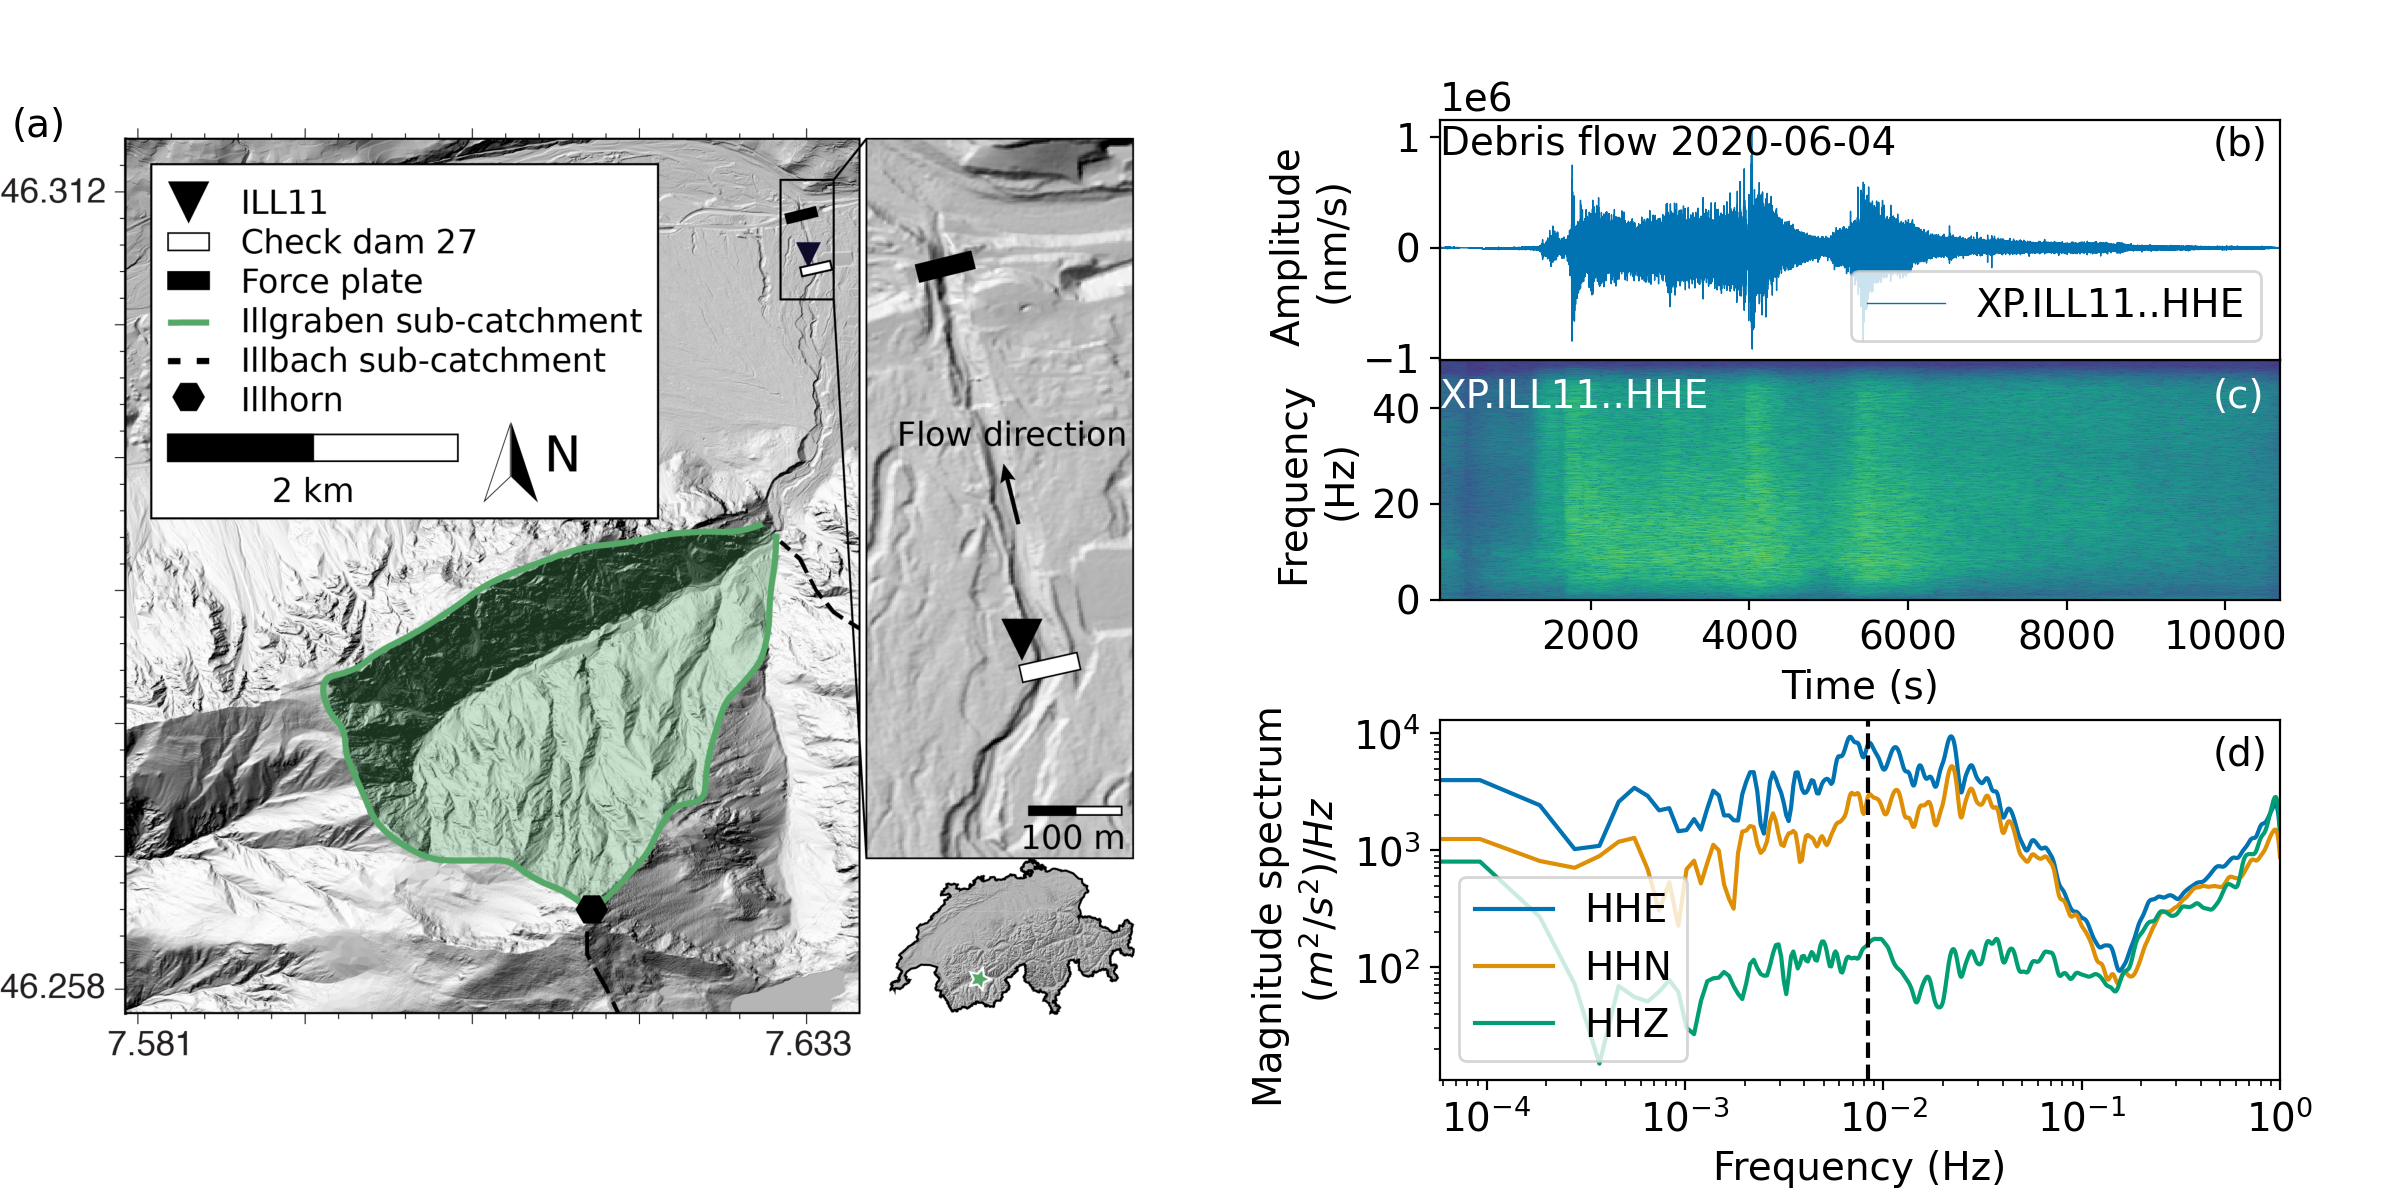

/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


[]

In [28]:
# Plot figure 2 in paper
from matplotlib import colors

fig = plt.figure(figsize = (12, 6))
    # [left bottom width height] 
axbigger = fig.add_axes([0.0, 0.1, 0.5, 0.8]) # Map
axbig = fig.add_axes([0.6, 0.1, 0.35, 0.3]) # Spectrum
ax4 = fig.add_axes([0.6, 0.5, 0.35, 0.2]) # Waveform
ax3 = fig.add_axes([0.6, 0.7, 0.35, 0.2]) # Spectrogram

#fac = 0.3
#i = 0
#j = 0

ns= 20 * 1024 # Number of samples per window to compute spectrogram

colors1 = sns.color_palette('colorblind', 3)
img = mpimg.imread('../figs/map_illgraben.png')
axbigger.imshow(img)

axbigger.axis('off')
for tr, co in zip(st[::-1],colors1[::-1]):

    if tr.stats.channel == 'HHE':
        ax3.plot(tr.times(), tr.data, color = co, label=tr.id, linewidth=0.5)
        f, t, Sxx = signal.spectrogram(tr.data, 100, nperseg=ns, noverlap = 0.9*ns, scaling='density')
        ax4.pcolormesh(t, f, Sxx, norm=colors.PowerNorm(gamma=0.05), shading='auto', cmap='viridis', rasterized=True)
        ax4.set_ylabel('Frequency \n(Hz)')

for key, co in zip(konno_specs,colors1):
    axbig.loglog(freqs[key], konno_specs[key], color=co, label=key)
for key, co in zip(konno_specs_noise,colors1):
    axbig.loglog(freqs[key], konno_specs_noise[key], linestyle = ":", color=co)

axbig.set_ylabel('Magnitude spectrum \n$(m^2/s^2)/Hz$')
axbig.set_xlabel('Frequency (Hz)')
axbig.axvline(1/120, color="k", linestyle="--")

axbig.set_xlim(freqs[key][0], 1)
axbig.legend(loc="lower left")
ax4.set_xlim(t[0], t[-1])   
ax3.set_xlim(t[0], t[-1])   
ax3.legend(loc='lower right')

ax3.set_ylabel("Amplitude \n(nm/s)")
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax3.text(100, 0.8* max(tr.data), f"Debris flow {tr.stats.starttime.date}")
ax4.text(100, 40, 'XP.ILL11..HHE', color='white')
ax4.set_xlabel("Time (s)")

annot = ['(a)','(b)', '(c)', '(d)']
axes = (axbigger,ax3, ax4, axbig)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(d)':
        ax.text(xlim[0] + 0.46*(xlim[1] - xlim[0]), ylim[1] - 0.6*(ylim[1] - ylim[0]), an)
    if an == '(a)':
        ax.text(xlim[0] + 0.01*(xlim[1] - xlim[0]), ylim[1] - 0.01*(ylim[1] - ylim[0]), an, color='black')
    elif an == '(b)':
        ax.text(xlim[0] + 0.92*(xlim[1] - xlim[0]), ylim[1] - 0.15*(ylim[1] - ylim[0]), an)
    elif an == '(c)':
        ax.text(xlim[0] + 0.92*(xlim[1] - xlim[0]), ylim[1] - 0.2*(ylim[1] - ylim[0]), an, color='white')
        

ax3.xaxis.set_ticks([])
axbigger.yaxis.set_ticks([])
axbigger.xaxis.set_ticks([])


In [71]:
"""
Get data for figure 5 in paper
"""
sigs = obspy.read('../data/illgraben_seismic_data/trimmed_data/*_signal.mseed')
tilts = obspy.read('../data/illgraben_tilt_data/*.mseed')
sigs = sigs.select(channel="*E") 

# Remove outliers with noise
tilts.remove(tilts[5]) # Remove July 3, 2019 event with low amplitudes (flood?) and without force plate data
sigs.remove(sigs[5])
tilts.remove(tilts[6]) # Remove July 26, 2019 event with overlapping long-period noise
sigs.remove(sigs[6])
tilts.remove(tilts[6]) # Remove August 11, 2019 event with overlapping long-period noise
sigs.remove(sigs[6])
tilts.remove(tilts[10]) # Remove June 9, 2020 event with low amplitudes (flood?) and without force plate data
sigs.remove(sigs[10])

14 Trace(s) in Stream:
XP.ILL11..BHE | 2019-06-10T17:35:50.995000Z - 2019-06-10T20:35:50.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-06-10T22:12:51.995000Z - 2019-06-11T01:12:51.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-06-21T18:45:06.995000Z - 2019-06-21T21:45:06.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-07-01T22:30:30.995000Z - 2019-07-02T01:30:30.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-07-02T21:47:13.995000Z - 2019-07-03T00:47:13.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-07-15T03:22:57.995000Z - 2019-07-15T06:22:57.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-08-20T16:10:13.995000Z - 2019-08-20T19:10:13.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..HHE | 2020-06-04T14:42:22.000000Z - 2020-06-04T17:42:22.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHE | 2020-06-07T08:27:19.000000Z - 2020-06-07T11:27:19.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHE | 2020-06-08T16:57:53.000000Z - 2020-06-08T19:57:53.000000Z

<IPython.core.display.Javascript object>


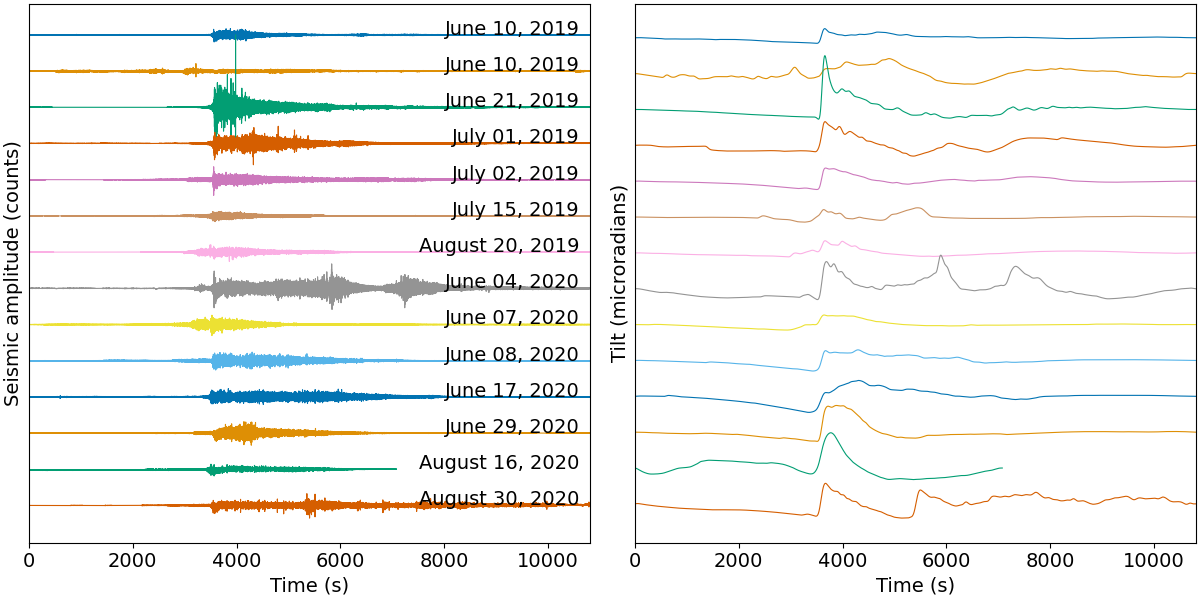

[]

In [73]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
axs = fig.subfigures(1, 2)

maxsig = np.max([np.max(tr.data) for tr in sigs]) # Get maximum amplitudes from signals
maxtilt = np.max([np.max(tr.data) for tr in tilts])

fac = 0.5 # Define factor to change spacing between events
fact = 0.15
i = 0
j = 0

ax2 = axs[0].subplots(1,1)
ax3 = axs[1].subplots(1,1)

colors2 = sns.color_palette('colorblind', len(sigs))
for tr1, sig1, co in zip(tilts, sigs, colors2):  
    ax3.plot(tr1.times(), 1.5*fact*tr1.copy().data-i, color = co, label=f"{tr1.stats.starttime.date.strftime('%d %B, %Y')}", linewidth=0.8)
    ax2.plot(sig1.times(), sig1.copy().data-j, color = co, label=f"{tr1.stats.starttime.date.strftime('%d %B, %Y')}", linewidth=0.8)
    ax2.text(10600, -j, sig1.stats.starttime.date.strftime('%B %d, %Y'), ha='right')
    i += fact*maxtilt
    j += fac*maxsig

ax2.set_xlim(0, 10800)
ax3.set_xlim(0, 10800)
ax2.yaxis.set_ticks([])
ax2.set_ylabel('Seismic amplitude (counts)')
ax3.set_ylabel('Tilt (microradians)')
ax2.set_xlabel('Time (s)')
ax3.set_xlabel('Time (s)')
ax3.yaxis.set_ticks([])

### USGS debris flow flume

In [84]:
# Get information from info file
loc = "USGS" # Set location
df = info[info['location'] == loc].copy().reset_index() 
times = list(df['time'])
print(times)

['2016-06-14T21:53:58', '2016-06-15T21:47:29', '2016-06-16T22:26:26', '2016-06-21T18:57:21', '2016-06-22T19:10:54', '2016-06-23T14:52:50', '2017-05-23T18:58:35.024235Z', '2017-05-24T18:52:30.558438Z', '2017-05-25T18:29:35.776199Z']


In [94]:
def tilt_above_fc(st, inv):
    """
    Get tilt for frequencies above corner frequency (after Wielandt 1999)
    Assuming that all recorded ground velocity in this frequency is a result of tilt 
    rather than translational ground motion
    :param st: Stream containing horizontal and vertical compontents
    :type st: obspy.core.stream.Stream
    :param inv: Inventory containing belonging instrument responses
    :type inv: obspy.core.inventory.inventory.Inventory
    :return: obspy Stream containing rotatet seismic data converted to tilt in microradians
    """
    st1 = st.copy()
    #st1.filter('bandpass', freqmin=1/120, freqmax=1, corners=2, zerophase=False)
    st1.remove_response(inventory = inv, output = 'ACC', plot=False)
    st1.rotate(method='->ZNE', inventory=inv)
    st1.rotate('NE->RT', back_azimuth=55.+180.).detrend('demean')
    st1.detrend('demean')
    st1.taper(0.01)
    #st1.filter('lowpass', freq = 1/0, corners=2, zerophase=False)
    st1.filter('bandpass', freqmin=1/120, freqmax=1/10, corners = 2, zerophase=True)
    for tr in st1:
    #    tr.data -= 4.93e-11
        tr.data = tr.data/-9.81 *1e6
    return st1

def process_tilt_data(st, t1, t2):
    """
    Process data from tiltmeters
    :param st: Stream containing horizontal and vertical compontents
    :type st: obspy.core.stream.Stream
    :param t1: time window before event
    :type t1: int
    :param t2: time after event
    :type t2: int
    """
    for tr in tm:
        tr.data = tr.data*0.03
    tm.detrend('demean')
    tm.detrend('linear')
    tm.taper(0.05)
    tm1 = tm.copy().filter('bandpass', freqmin=1/120, freqmax=1/10, zerophase=True, corners=2)
    #tm1 = tm.copy().filter('lowpass', freq=1/10, zerophase=False, corners=2)
    tm2 = tm1.copy()
    tmr = tm2.rotate('NE->RT', back_azimuth=55.+180.)
    tme = tmr.select(channel='BHR')
    for tr, t in zip(tme, times[1:]):
        t = obspy.UTCDateTime(t)
        tr.trim(t - t1, t + t2)
    tme.detrend('linear') 
    return tme

In [83]:
# Process data of flume experiments

# Define window length of data
tc = 200 # 3x3600s will be taken from data
station = "E02"

for idx, row in df.iterrows(): 
    # Read data files and preprocess data
    t = obspy.UTCDateTime(row['time'])
    print(f"{loc}, Event: {t}")
    ti = tilt(t, loc, station)
    print(ti.stream)
    st = ti.stream.copy()
    st.trim(t - 1*tc, t + 1*tc)
    st.copy().write(f'../data/{loc}_seismic_data/trimmed_data/{loc}_{t.isoformat()}_signal.mseed', format='MSEED')

    # Get sensitivity
    sens = st[0].stats.response.instrument_sensitivity.value

    # Demean/taper
    st.merge(fill_value='interpolate')
    st.detrend('demean')
    st.detrend('linear')
    st.taper(0.01)

    # Get tilt
    st1 = tilt_above_fc(st, ti.inventory)
    
    # Only save radial component
    tra = st1[0].copy()
    tra.write(f'../data/{loc}_tilt_data/{loc}_{station}_{t.isoformat()}_tilt.mseed', format='MSEED')



USGS, Event: 2016-06-14T21:53:58.000000Z
3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-14T20:53:58.000000Z - 2016-06-14T22:53:58.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CH2 | 2016-06-14T20:53:58.000000Z - 2016-06-14T22:53:58.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CHZ | 2016-06-14T20:53:58.000000Z - 2016-06-14T22:53:58.000000Z | 500.0 Hz, 3600001 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


USGS, Event: 2016-06-15T21:47:29.000000Z
3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-15T20:47:29.000000Z - 2016-06-15T22:47:29.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CH2 | 2016-06-15T20:47:29.000000Z - 2016-06-15T22:47:29.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CHZ | 2016-06-15T20:47:29.000000Z - 2016-06-15T22:47:29.000000Z | 500.0 Hz, 3600001 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


USGS, Event: 2016-06-16T22:26:26.000000Z
3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-16T21:26:26.000000Z - 2016-06-16T23:26:26.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CH2 | 2016-06-16T21:26:26.000000Z - 2016-06-16T23:26:26.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CHZ | 2016-06-16T21:26:26.000000Z - 2016-06-16T23:26:26.000000Z | 500.0 Hz, 3600001 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


USGS, Event: 2016-06-21T18:57:21.000000Z
3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-21T17:57:21.000000Z - 2016-06-21T19:57:21.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CH2 | 2016-06-21T17:57:21.000000Z - 2016-06-21T19:57:21.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CHZ | 2016-06-21T17:57:21.000000Z - 2016-06-21T19:57:21.000000Z | 500.0 Hz, 3600001 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


USGS, Event: 2016-06-22T19:10:54.000000Z
3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-22T18:10:54.000000Z - 2016-06-22T20:10:54.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CH2 | 2016-06-22T18:10:54.000000Z - 2016-06-22T20:10:54.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CHZ | 2016-06-22T18:10:54.000000Z - 2016-06-22T20:10:54.000000Z | 500.0 Hz, 3600001 samples


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


USGS, Event: 2016-06-23T14:52:50.000000Z
3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-23T13:52:50.000000Z - 2016-06-23T15:52:50.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CH2 | 2016-06-23T13:52:50.000000Z - 2016-06-23T15:52:50.000000Z | 500.0 Hz, 3600001 samples
ZK.E02..CHZ | 2016-06-23T13:52:50.000000Z - 2016-06-23T15:52:50.000000Z | 500.0 Hz, 3600001 samples
USGS, Event: 2017-05-23T18:58:35.024235Z


/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


FileNotFoundError: [Errno 2] No such file or directory: '../data/USGS_seismic_data/ZK/E02/ZK.E02....2016.143'

In [89]:
"""
Get data for figure 2 in paper
"""
# Get tiltmeter data
tm = obspy.read('../data/USGS_tiltmeter_data/3662*')
tme = process_tilt_data(tm, 40, 60)

# Get raw seismic data to plot event
t = obspy.UTCDateTime(times[4])
st = obspy.read(f'../data/USGS_seismic_data/ZK/E02/*{t.julday}')
inv = obspy.read_inventory('../data/USGS_seismic_data/response/usgs_E02_2016.xml')
st.remove_sensitivity(inv)
for tr in st:
    tr.data *= 1e9
    
st.trim(t-20, t + 60)


3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-22T19:10:34.000000Z - 2016-06-22T19:11:54.000000Z | 500.0 Hz, 40001 samples
ZK.E02..CH2 | 2016-06-22T19:10:34.000000Z - 2016-06-22T19:11:54.000000Z | 500.0 Hz, 40001 samples
ZK.E02..CHZ | 2016-06-22T19:10:34.000000Z - 2016-06-22T19:11:54.000000Z | 500.0 Hz, 40001 samples

In [92]:
# Get smoothed spectrum
# Get noise
t = obspy.UTCDateTime(times[4])
st_full = obspy.read(f'../data/USGS_seismic_data/ZK/E02/*{t.julday}')
st_full.remove_sensitivity(inv)
#for tr in st:
#    tr.data *= 1e9
st_full.detrend("demean")
st_full.taper(0.01)
#st.filter("bandpass", freqmin=1/120, freqmax=100)
st_sig = st_full.copy().trim(t + 2, t + 52)   
st_noise = st_full.copy().trim(t-110, t - 60)

# Apply konno_ohmachi_smoothing

freqs = {}
konno_specs = {}
freqs_noise = {}
konno_specs_noise = {}
for tr in st_sig:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr1.stats.sampling_rate ,color = co,linewidth=0.7)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs[tr.stats.channel] = freq
    konno_specs[tr.stats.channel] = new_spectra
for tr in st_noise:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr1.stats.sampling_rate ,color = co,linewidth=0.7)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs_noise[tr.stats.channel] = freq
    konno_specs_noise[tr.stats.channel] = new_spectra

<IPython.core.display.Javascript object>


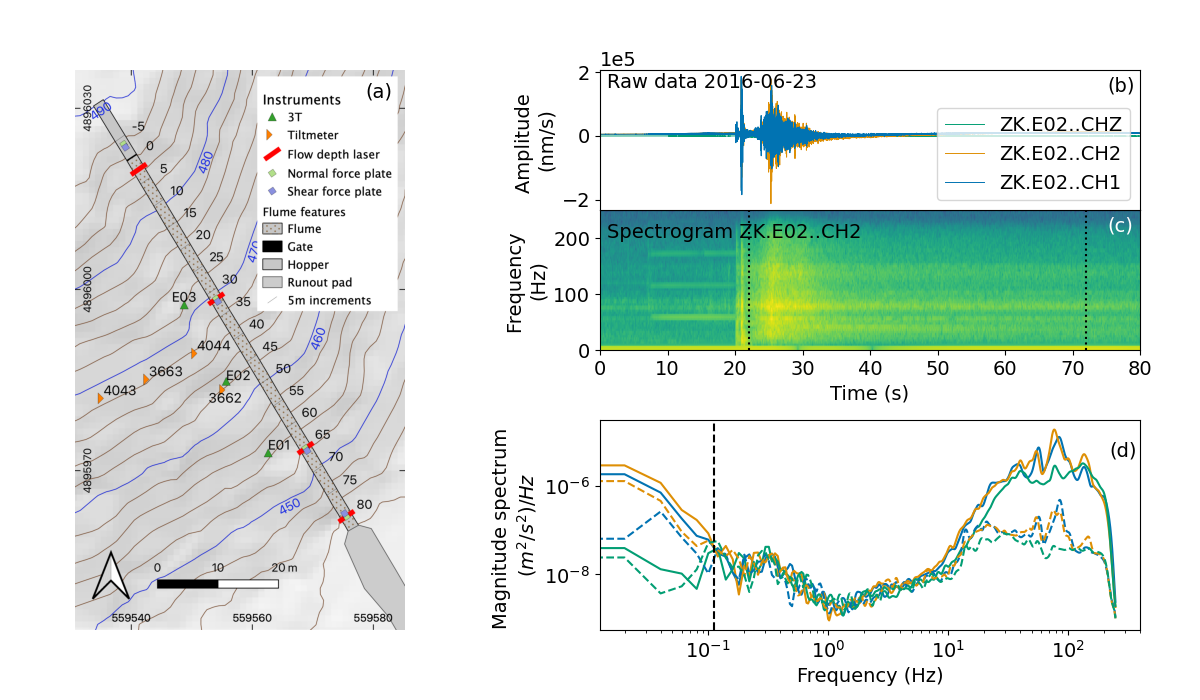

In [93]:
"""
Plot figure 2 in paper
"""
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
img = mpimg.imread('../figs/map_usgs.png')


#st1 = st.copy().differentiate()

fig = plt.figure(figsize = (12, 7))
    # [left bottom width height] 
axbigger = fig.add_axes([0.0, 0.1, 0.4, 0.8]) # Map
axbig = fig.add_axes([0.5, 0.1, 0.45, 0.3]) # Spectrum
ax3 = fig.add_axes([0.5, 0.5, 0.45, 0.2]) # Waveform
ax4 = fig.add_axes([0.5, 0.7, 0.45, 0.2]) # Spectrogram


colors = sns.color_palette('colorblind', 3)


axbigger.imshow(img)
#ax0.set_title('2016 experiment setup')
axbigger.axis('off')
ax3.specgram(st[1].data, NFFT=130, Fs=st[1].stats.sampling_rate,  scale='dB', rasterized=True)
for tr, tr1, co in zip(st[::-1], st1[::-1], colors[::-1]):
    ax4.plot(tr.times(), tr, color = co, label=tr.id, linewidth=0.7)
for channel,co in zip(freqs,colors):
    axbig.loglog(freqs[channel], konno_specs[channel], color=co, label=channel)
for channel,co in zip(freqs_noise,colors):
    axbig.loglog(freqs_noise[channel], konno_specs_noise[channel], color=co, linestyle="--", label=channel)
axbig.axvline(1/9, color='k', linestyle='--')
#axbig.axvline(1/120, color='k', linestyle=':')
  
#axbig.axvspan(1/15, 1/9, alpha=0.1, color='grey')
ax4.legend(loc='lower right', fontsize=14)
ax4.set_ylabel('Amplitude \n(nm/s)')
ax4.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax4.text(1, 0.8* max(tr.data), f'Raw data {tr1.stats.starttime.date}')
ax4.set_xlim(0, 80)
ax3.text(1, 200, f'Spectrogram {st[1].id}')
ax3.set_ylabel('Frequency \n(Hz)')
axbig.set_ylabel('Magnitude spectrum \n$(m^2/s^2)/Hz$')
ax3.axvline(22, color='k', linestyle=':')
ax3.axvline(72, color='k', linestyle=':')



ax3.set_xlim(0, 80)
axbig.set_xlabel('Frequency (Hz)')
#ax1[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax3.set_xlabel("Time (s)")
#ax1[2].set_xscale('log')
ax4.get_xaxis().set_ticks([])
#ax1[0].get_xaxis().set_visible(False)
#box = ax2.get_position()
#ax2.set_position([box.x0, box.y0, box.width * 0.9, box.height])
annot = ['(a)','(b)', '(c)', '(d)']
axes = (axbigger, ax4, ax3, axbig)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(d)':
        ax.text(xlim[0] + 0.55*(xlim[1] - xlim[0]), ylim[1] - 0.85*(ylim[1] - ylim[0]), an)
    elif an == '(a)':
        ax.text(xlim[0] + 0.88*(xlim[1] - xlim[0]), ylim[1] - 0.05*(ylim[1] - ylim[0]), an, color='black')
    elif an == '(b)':
        ax.text(xlim[0] + 0.94*(xlim[1] - xlim[0]), ylim[1] - 0.15*(ylim[1] - ylim[0]), an)
    elif an == '(c)':
        ax.text(xlim[0] + 0.94*(xlim[1] - xlim[0]), ylim[1] - 0.15*(ylim[1] - ylim[0]), an, color='white')



In [ ]:
"""
Get data for figure 4 in paper
"""

## Get correlations

## Model tilt

### Step in acceleration